# 数据集训练

In [1]:
#库
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
#加载并归一化训练、测试数据集
transform=transforms.Compose( #组合多个图像变换操作
    [
        transforms.ToTensor(), #图像转换Tensor

        #每个通道归一化
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ]
)

#加载数据集
trainset=torchvision.datasets.CIFAR10(
    root='./data', #存储路径
    train=True,
    download=True,
    transform=transform #应用定义的数据预处理流程
)

#创建训练数据加载器
trainloader=torch.utils.data.DataLoader(
    trainset,
    batch_size=4, #每个小批量4个样本
    shuffle=True, #每个epoch打乱数据顺序
    num_workers=2 #使用两个子进程进行数据加载
)

testset = torchvision.datasets.CIFAR10(
    root='./data', 
    train=False,
    download=True, 
    transform=transform
)

testloader = torch.utils.data.DataLoader(
    testset, 
    batch_size=4,
    shuffle=False, 
    num_workers=2
)

#数据类别标签选择
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

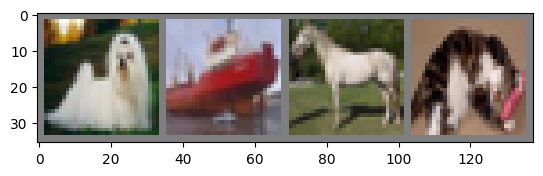

  dog  ship horse   cat


In [ ]:
#展示一部分训练图片
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):

    #反归一化操作，恢复原始像素范围
    img=img/2 +0.5
    npimg=img.numpy() #转为np数组


    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

#随机获取图片
dataiter=iter(trainloader) #从训练数据加载器创建迭代器

#获取一个batch的数据
images,labels=next(dataiter)

#展示图片
#拼接图片
imshow(torchvision.utils.make_grid(images))

#标签打印
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
#卷积神经网络定义
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__() #继承父类初始化

        self.conv1 = nn.Conv2d(3, 6, 5) #第一个卷积层：输入通道3，输出通道6,5x5卷积核
        self.pool = nn.MaxPool2d(2, 2) #最大池化层
        self.conv2 = nn.Conv2d(6, 16, 5) #第二卷积层

        #全连接层
        self.fc1 = nn.Linear(16 * 5 * 5, 120) 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    #前向传播
    def forward(self, x):
        # 卷积层1 -> ReLU激活 -> 池化
        x = self.pool(F.relu(self.conv1(x)))
        # 卷积层2 -> ReLU激活 -> 池化
        x = self.pool(F.relu(self.conv2(x)))
        
        #展平特征图
        x = x.view(-1, 16 * 5 * 5)
        
        # 全连接层1、2 -> ReLU激活
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        # 最终输出层（不接激活函数，后续配合CrossEntropyLoss使用）
        x = self.fc3(x)
        return x


net = Net()

In [8]:
#损失函数定义
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
#利用训练样本数据训练网络
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入数据
        inputs, labels = data

        # 设置参数梯度为0
        optimizer.zero_grad()

        # 前向传播 + 反向传播 + 优化器
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('完成训练')

[1,  2000] loss: 2.254
[1,  4000] loss: 1.885
[1,  6000] loss: 1.673
[1,  8000] loss: 1.585
[1, 10000] loss: 1.520
[1, 12000] loss: 1.477
[2,  2000] loss: 1.415
[2,  4000] loss: 1.356
[2,  6000] loss: 1.357
[2,  8000] loss: 1.357
[2, 10000] loss: 1.287
[2, 12000] loss: 1.289
完成训练


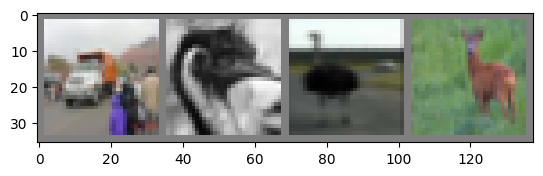

truck  bird  bird  deer


In [10]:
# 随机获取图片
dataiter = iter(trainloader)
images, labels = next(dataiter)

#展示图片
imshow(torchvision.utils.make_grid(images))
# 打印标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [11]:
outputs = net(images)

In [12]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog truck horse   dog


In [13]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [14]:
#各类别的预测情况
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 62 %
Accuracy of  bird : 26 %
Accuracy of   cat : 45 %
Accuracy of  deer : 60 %
Accuracy of   dog : 57 %
Accuracy of  frog : 52 %
Accuracy of horse : 49 %
Accuracy of  ship : 61 %
Accuracy of truck : 66 %


# 作业

In [16]:
#神经网络创建
import torch.nn as nn
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self, input_shape=(3, 32, 32)):
        """全连接网络结构定义
        Args:
            input_shape (tuple): 输入数据维度，默认CIFAR-10的(3,32,32)
        """
        super(Net2, self).__init__()
        
        # 展平层：将图像数据转换为向量
        self.flatten = nn.Flatten()
        
        # 计算展平后的特征维度
        self.flat_features = input_shape[0] * input_shape[1] * input_shape[2]
        
        # 全连接层定义
        self.fc1 = nn.Linear(self.flat_features, 120)  # 第一隐藏层
        self.fc2 = nn.Linear(120, 84)                  # 第二隐藏层
        self.fc3 = nn.Linear(84, 10)                   # 输出层

    def forward(self, x):
        """前向传播流程"""
        # 展平输入 [batch, C, H, W] → [batch, C*H*W]
        x = self.flatten(x)
        
        # 第一隐藏层 + ReLU激活
        x = F.relu(self.fc1(x))
        
        # 第二隐藏层 + ReLU激活
        x = F.relu(self.fc2(x))
        
        # 输出层（不使用激活函数）
        x = self.fc3(x)
        return x

# 实例化网络（适配CIFAR-10数据集）
net2 = Net2(input_shape=(3, 32, 32))

In [17]:
#模型训练
#利用训练样本数据训练网络
for epoch in range(2):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 获取输入数据
        inputs, labels = data

        # 设置参数梯度为0
        optimizer.zero_grad()

        # 前向传播 + 反向传播 + 优化器
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # 每2000打印一次
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('完成训练')

[1,  2000] loss: 2.304
[1,  4000] loss: 2.304
[1,  6000] loss: 2.304
[1,  8000] loss: 2.304
[1, 10000] loss: 2.304
[1, 12000] loss: 2.304
[2,  2000] loss: 2.304
[2,  4000] loss: 2.304
[2,  6000] loss: 2.303
[2,  8000] loss: 2.304
[2, 10000] loss: 2.304
[2, 12000] loss: 2.305
完成训练


In [18]:
#准确率
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 9 %


In [19]:
#各类别的预测情况
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane :  0 %
Accuracy of   car : 69 %
Accuracy of  bird :  0 %
Accuracy of   cat :  9 %
Accuracy of  deer :  2 %
Accuracy of   dog :  1 %
Accuracy of  frog :  0 %
Accuracy of horse :  0 %
Accuracy of  ship :  3 %
Accuracy of truck :  4 %
